In [1]:
from utils.CoopEnv import CoopEnv
from utils.IACagent import Agent

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [3]:
# Set constant hyperparameters
n = 10
num_of_tasks  = 5
num_of_sims = 1
step_limit = 5000

In [4]:
lower_bound = -0.99
upper_bound = 2.00
comm_array = np.linspace(lower_bound, upper_bound, 300)

comm_space = len(comm_array)

In [5]:
env = CoopEnv(n=n, num_of_tasks=num_of_tasks)

In [6]:
steps_to_complete = np.zeros((num_of_sims, step_limit+1))
comm_rec_actions = np.zeros((step_limit, env.n))
move_rec_actions = np.zeros((step_limit, env.n))
rec_rewards = np.zeros((step_limit, env.n))

agentlist = {i: Agent(comm_space, alr=1e-4, vlr=4e-4 ) for i in range(env.n)}

In [7]:
def main():

    for s in range(num_of_sims):

        print("----------------------------------")
        print(f"Starting training simulation {s}:")
        print("----------------------------------")

        # reinitialise agent list each sim
        # reset the environment
        observations = env.reset(n=n, num_of_tasks =num_of_tasks)

        # begin training loop
        t = 0
        while t < step_limit:
            print(t, end='\r')

            sys_actions = np.zeros((env.n, 2)) # column 0 for move actions and column 1 for comm actions
            # collect move and comm  action for each agent
            sys_actions = np.array([agentlist[i].choose_action(observations[i]) for i in range(env.n)])

            action_move = sys_actions[:,0]
            action_comm = comm_array[sys_actions[:,1]]

            next_observations, rewards, termination, info = env.step(action_move, action_comm) # env.step

            comm_rec_actions[t] = action_comm  # output from actor (comm head)
            move_rec_actions[t] = action_move

            for i in range(env.n): # train each agent
                agentlist[i].train(observations[i], sys_actions[i, :], rewards[i], next_observations[i])

            # advance state
            observations = next_observations
            # record average system reward score
            steps_to_complete[s, t+1] = sum(rewards)/env.n
            rec_rewards[t, :] = rewards

            # increment timestep and loop
            t +=1


In [8]:
if __name__ == "__main__":

    #cProfile.run('main()')
    main()


----------------------------------
Starting training simulation 0:
----------------------------------


In [9]:
# save reward and actions
np.save(f'n{n}t{num_of_tasks}_cum_rew_bc', steps_to_complete)
np.save(f'n{n}t{num_of_tasks}_actions_bc', comm_rec_actions)

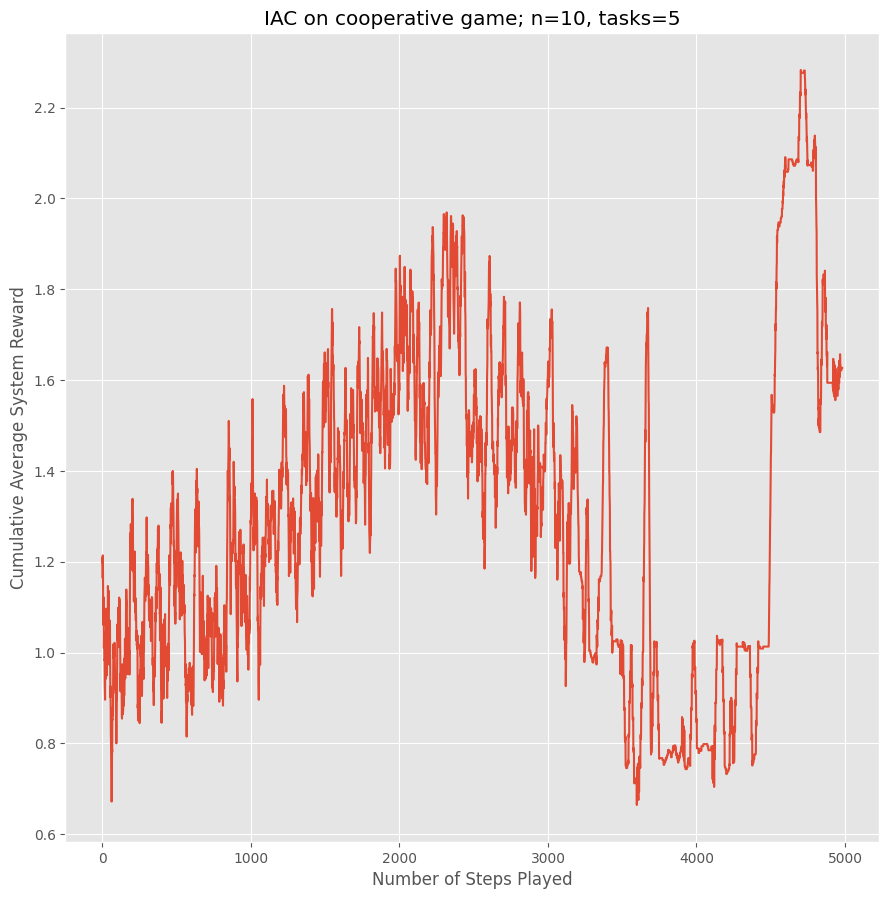

In [10]:
plt.style.use('ggplot')
b = np.mean(steps_to_complete, axis=0)
s_dev = np.std(steps_to_complete, axis=0)

def moving_average(arr, window_size):
    moving_averages = []
    for i in range(len(arr) - window_size + 1):
        window = arr[i:i + window_size]
        average = sum(window) / window_size
        moving_averages.append(average)
    return moving_averages

plt.xlabel('Number of Steps Played')
plt.ylabel('Cumulative Average System Reward')
plt.title(f'IAC on cooperative game; n={n}, tasks={num_of_tasks}')
fig = plt.gcf()
fig.set_size_inches(10.5, 10.5)
plt.plot(moving_average(b,20))

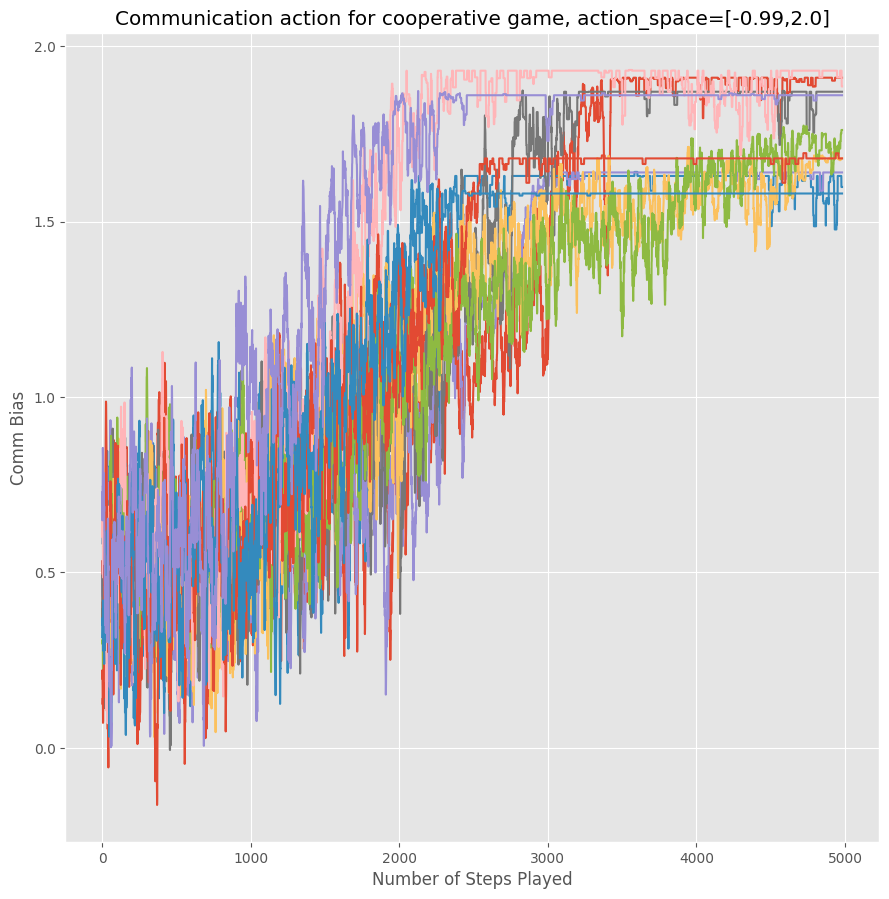

In [11]:
plt.xlabel('Number of Steps Played')
plt.ylabel('Comm Bias')
plt.title(f'Communication action for cooperative game, action_space=[{lower_bound},{upper_bound}]')
fig = plt.gcf()
fig.set_size_inches(10.5, 10.5)

plt.plot(moving_average(comm_rec_actions,20))

In [12]:
# Get coalition structure
converged_structure = np.zeros((num_of_tasks, env.n))
task = 0
for C in env.CS:
    indices = [int(a)-1 for a in list(C)]
    converged_structure[task, indices] = 1
    task+=1

print(converged_structure)
np.save(f'n{n}t{num_of_tasks}_cstruct_cnf0.npy', converged_structure)

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 1. 1. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


[{'2'}, set(), {'6'}, {'4', '7', '3', '1', '10', '8', '9'}, {'5'}]


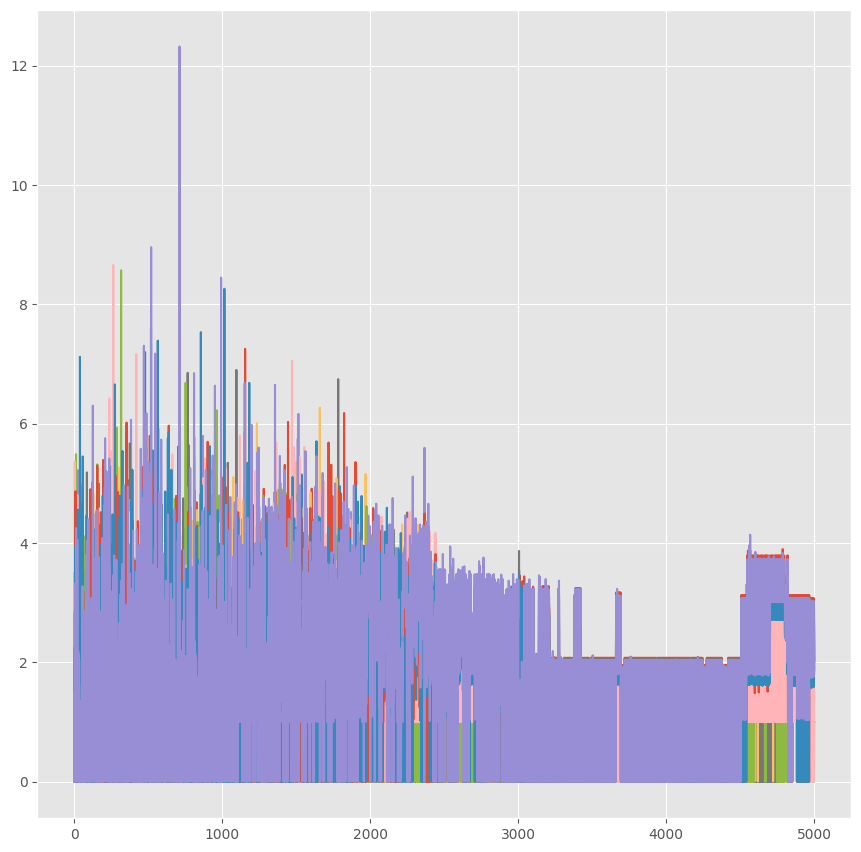

In [13]:
print(env.CS)
for j in range(env.n):
    plt.plot(rec_rewards[:,j])

fig = plt.gcf()
fig.set_size_inches(10.5, 10.5)